In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in the 1/4 degree data and performing energy decomposition

In [2]:
#1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/nw2_0.25deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
%%time
xh_025 = fs.xh.values
yh_025 = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)

done part 1
done part 2
(100, 15, 560, 240)
CPU times: user 11.1 s, sys: 9.12 s, total: 20.2 s
Wall time: 49.8 s


In [4]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_025=KE_eddy_BT+KE_mean_BT
KE_BC_tot_025=KE_eddy_BC+KE_mean_BC
KE_tot_025=KE_BT_tot_025+KE_BC_tot_025


fraction_BT_025=KE_BT_tot_025/KE_tot_025
fraction_BT_mean_025=KE_mean_BT/KE_tot_025
fraction_BT_eddy_025=KE_eddy_BT/KE_tot_025

fraction_BC_025=KE_BC_tot_025/KE_tot_025 #when you divide zero/zero it's a nan
fraction_BC_mean_025=KE_mean_BC/KE_tot_025
fraction_BC_eddy_025=KE_eddy_BC/KE_tot_025

KE_eddy_025 = KE_eddy_BT+ KE_eddy_BC
KE_mean_025 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 3.32 s, sys: 5.7 s, total: 9.01 s
Wall time: 9.05 s


## Reading in the 1/8 degree data and performing energy decomposition

In [14]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/scratch/gmarques/NW2_TMP/nw2_0.125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [16]:
%%time
xh_0125 = fs.xh.values
yh_0125 = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)


done part 1
done part 2
(100, 15, 1120, 480)
CPU times: user 34.8 s, sys: 14.4 s, total: 49.2 s
Wall time: 1min 19s


In [17]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_0125=KE_eddy_BT+KE_mean_BT
KE_BC_tot_0125=KE_eddy_BC+KE_mean_BC
KE_tot_0125=KE_BT_tot_0125+KE_BC_tot_0125


fraction_BT_0125=KE_BT_tot_0125/KE_tot_0125
fraction_BT_mean_0125=KE_mean_BT/KE_tot_0125
fraction_BT_eddy_0125=KE_eddy_BT/KE_tot_0125

fraction_BC_0125=KE_BC_tot_0125/KE_tot_0125 #when you divide zero/zero it's a nan
fraction_BC_mean_0125=KE_mean_BC/KE_tot_0125
fraction_BC_eddy_0125=KE_eddy_BC/KE_tot_0125

KE_eddy_0125 = KE_eddy_BT+ KE_eddy_BC
KE_mean_0125 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 10.6 s, sys: 10.1 s, total: 20.7 s
Wall time: 20.7 s


## Reading in the 1/16 degree data and performing energy decomposition

In [22]:
#1/16 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
                        'sub05/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/scratch/gmarques/NW2_TMP/nw2_0.0625deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [17]:
%%time
#COMPUTE KE AND THEN WEIGH BY THICKNESS
xh_00625 = fs.xh.values
yh_00625 = fs.yh.values

# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)
CPU times: user 2min 28s, sys: 1min 41s, total: 4min 10s
Wall time: 4min 21s


In [ ]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_00625=KE_eddy_BT+KE_mean_BT
KE_BC_tot_00625=KE_eddy_BC+KE_mean_BC
KE_tot_00625=KE_BT_tot_00625+KE_BC_tot_00625


fraction_BT_00625=KE_BT_tot_00625/KE_tot_00625
fraction_BT_mean_00625=KE_mean_BT/KE_tot_00625
fraction_BT_eddy_00625=KE_eddy_BT/KE_tot_00625

fraction_BC_00625=KE_BC_tot_00625/KE_tot_00625 #when you divide zero/zero it's a nan
fraction_BC_mean_00625=KE_mean_BC/KE_tot_00625
fraction_BC_eddy_00625=KE_eddy_BC/KE_tot_00625

KE_eddy_00625 = KE_eddy_BT+ KE_eddy_BC
KE_mean_00625 = KE_mean_BT+ KE_eddy_BC

done 1


In [ ]:
KE_mean_00625.shape

## Reading in the 1/32 degree data and performing energy decomposition

In [5]:
#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('sub01/ocean.stats.nc', decode_times=False)
#os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                        'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00000902.nc', decode_times=False)  #20 5-day averages
#av = xr.open_mfdataset(['averages_00000502.nc','averages_00000602.nc','averages_00000702.nc','averages_00000802.nc','averages_00000902.nc'], decode_times=False)  #20 5-day averages
%ls
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/nw2_0.03125deg_N15_baseline_hmix5
available_diags.000000  longmean_00000850.nc         sub01/
averages_00000402.nc    longmean_00000950.nc         sub02/
averages_00000502.nc    MOM_IC_1.nc                  sub03/
averages_00000602.nc    MOM_IC_2.nc                  sub04/
averages_00000702.nc    MOM_IC.nc                    sub04_sfc/
averages_00000802.nc    MOM_input@                   sub05/
averages_00000902.nc    MOM_layout@                  sub05_sfc/
CPU_stats               MOM_override                 sub06/
diag_table@             MOM_parameter_doc.all        sub06_sfc/
diag_table.final        MOM_parameter_doc.debugging  sub07/
diag_table.init         MOM_parameter_doc.layout     sub07_sfc/
diag_table.sfc          MOM_parameter_doc.short      sub08/
exitcode                ocean_geometry.nc            sub08_sfc/
INPUT/                  README                       submit_cheyenne
input.nml               RESTART/                     surface_0000

In [6]:
%%time
#COMPUTE KE AND THEN WEIGH BY THICKNESS
xh_003125 = fs.xh.values
yh_003125 = fs.yh.values

# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'][:,:].mean('time')#.compute().fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 20 5-day averages.
u  = av['u'][:,:];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'][:,:];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)
CPU times: user 2min 31s, sys: 1min 40s, total: 4min 11s
Wall time: 4min 28s


In [7]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_003125=KE_eddy_BT+KE_mean_BT
KE_BC_tot_003125=KE_eddy_BC+KE_mean_BC
KE_tot_003125=KE_BT_tot_003125+KE_BC_tot_003125


fraction_BT_003125=KE_BT_tot_003125/KE_tot_003125
fraction_BT_mean_003125=KE_mean_BT/KE_tot_003125
fraction_BT_eddy_003125=KE_eddy_BT/KE_tot_003125

fraction_BC_003125=KE_BC_tot_003125/KE_tot_003125 #when you divide zero/zero it's a nan
fraction_BC_mean_003125=KE_mean_BC/KE_tot_003125
fraction_BC_eddy_003125=KE_eddy_BC/KE_tot_003125

KE_eddy_003125 = KE_eddy_BT+ KE_eddy_BC
KE_mean_003125 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 48.3 s, sys: 1min 18s, total: 2min 7s
Wall time: 2min 7s


In [8]:
print('done')

done


done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions')

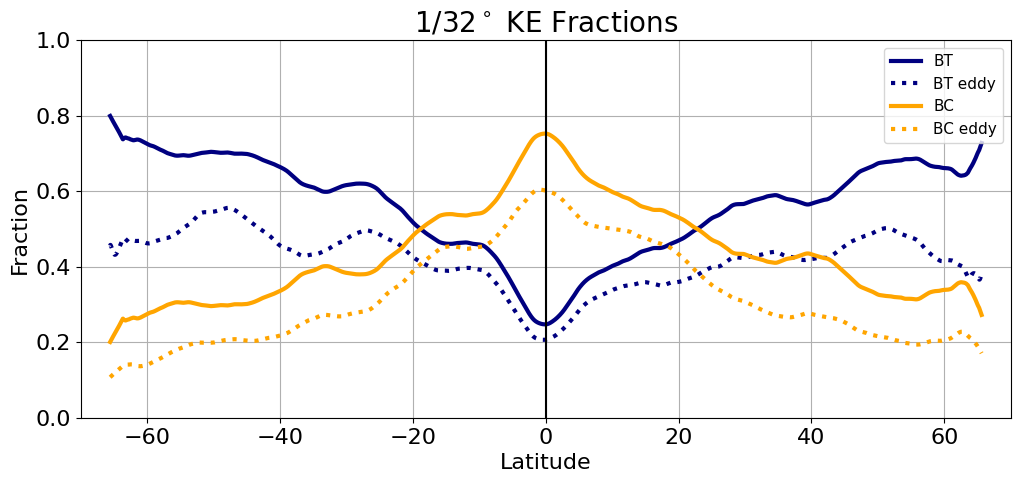

In [17]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
#plt.plot(yh_003125,np.convolve((fraction_BT_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BT_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh_003125,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
#plt.plot(yh_003125,np.convolve((fraction_BC_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh_003125,np.convolve((fraction_BC_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT eddy','BC','BC eddy'],loc='upper right',fontsize=11,handlelength=2)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions',fontsize=20)

done


Text(0.5, 1.0, '1/4$^\\circ$ KE Fractions')

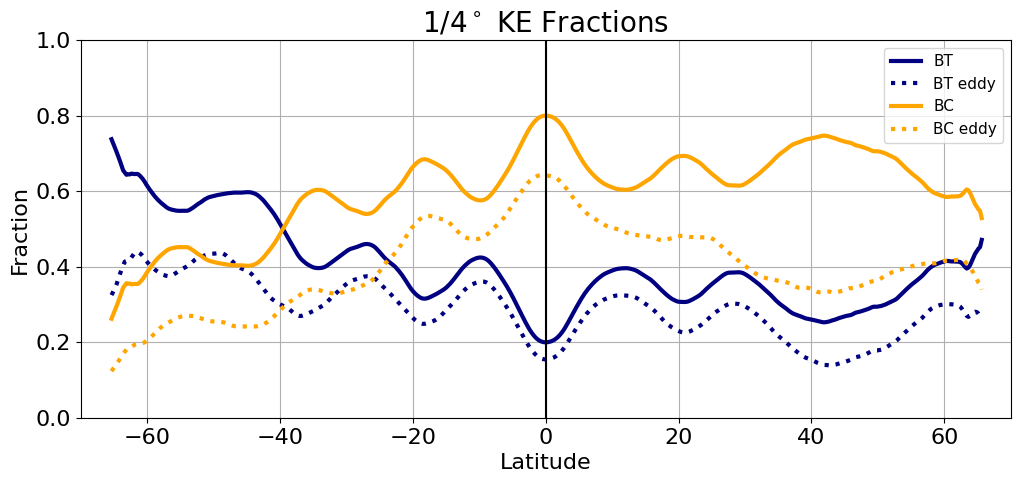

In [16]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BT_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
#plt.plot(yh_025,np.convolve((fraction_BT_mean_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BT_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve((fraction_BC_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
#plt.plot(yh_025,np.convolve((fraction_BC_mean_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh_025,np.convolve((fraction_BC_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT eddy','BC','BC eddy'],loc='upper right',fontsize=11,handlelength=2)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70,70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$ KE Fractions',fontsize=20)